# import libraries

In [29]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timm
# 导入所需库
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# 使用IPython的magic命令启用交互式matplotlib
%matplotlib inline
# Jupyter中更新图表需要使用这个

print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"当前GPU: {torch.cuda.get_device_name(0)}")

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


PyTorch版本: 2.6.0+cu126
CUDA是否可用: True
当前GPU: NVIDIA GeForce RTX 4060 Ti


# parameters

In [30]:
# 设置随机种子确保可重复性
torch.manual_seed(42)
np.random.seed(42)
print("设置随机种子: 42")

# 检查数据目录是否存在
data_root = 'Aerial_Landscapes'
if not os.path.exists(data_root):
    print(f"错误: 数据目录 '{data_root}' 不存在!")
else:
    print(f"找到数据目录: {data_root}")

# 设置训练参数
batch_size = 32
num_epochs = 3
learning_rate = 0.0001

print("\n训练参数配置:")
print(f"- 批次大小: {batch_size}")
print(f"- 训练轮数: {num_epochs}")
print(f"- 学习率: {learning_rate}")


设置随机种子: 42
找到数据目录: Aerial_Landscapes

训练参数配置:
- 批次大小: 32
- 训练轮数: 3
- 学习率: 0.0001


In [42]:
# 定义数据集类，支持数据划分
class AerialDataset(Dataset):
    def __init__(self, root_dir, transform=None, split_ratio=[0.6, 0.2, 0.2], mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.split_ratio = split_ratio
        self.mode = mode
        self.imgs = self._load_images()

        print(f"创建 {mode} 数据集:")
        print(f"- 类别数: {len(self.classes)}")
        print(f"- 类别: {self.classes}")
        print(f"- 图像数量: {len(self.imgs)}")
        print(f"- 划分比例: {split_ratio}")

    def _load_images(self):
        imgs = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            img_files = sorted(os.listdir(class_path))

            # 计算每个集合的图像数量
            total_images = len(img_files)
            train_size = int(total_images * self.split_ratio[0])
            val_size = int(total_images * self.split_ratio[1])

            # 根据模式选择相应的图像
            if self.mode == 'train':
                selected_files = img_files[:train_size]
            elif self.mode == 'val':
                selected_files = img_files[train_size:train_size + val_size]
            else:  # test
                selected_files = img_files[train_size + val_size:]

            for img_name in selected_files:
                imgs.append((os.path.join(class_path, img_name), self.class_to_idx[cls]))
        return imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path, label = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


# 数据预处理与增强
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 更大的初始尺寸
    transforms.RandomCrop(224),  # 随机裁剪
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # 随机缩放裁剪
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),  # 高斯模糊
    transforms.RandomSolarize(threshold=0.5, p=0.2),  # 曝光增强
    transforms.RandomRotation(20),  # 增加旋转角度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 添加平移
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 创建数据加载器
def create_dataloaders(root_dir, batch_size=32):
    print(f"创建数据加载器，batch_size={batch_size}...")
    train_dataset = AerialDataset(root_dir=root_dir, transform=train_transform, mode='train')
    val_dataset = AerialDataset(root_dir=root_dir, transform=val_test_transform, mode='val')
    test_dataset = AerialDataset(root_dir=root_dir, transform=val_test_transform, mode='test')

    print(f"数据集大小 - 训练: {len(train_dataset)}, 验证: {len(val_dataset)}, 测试: {len(test_dataset)}")

    # 打印每个类的数据分布
    class_counts = {}
    for _, label in train_dataset.imgs:
        class_name = train_dataset.classes[label]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1

    print("训练集类别分布:")
    for cls, count in class_counts.items():
        print(f"- {cls}: {count}张图像")

    # Windows环境下将num_workers设为0以避免线程错误
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0)

    return train_loader, val_loader, test_loader, train_dataset.classes


# 创建ViT模型
def create_model(num_classes=15, mode='train'):
    if mode == 'train':

        print(f"创建ViT模型, 类别数={num_classes}...")
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        model.head = nn.Linear(model.head.in_features, num_classes)
        # 打印模型结构
        print("\n完整模型结构:")
        print(model)

    else:
        model = timm.create_model('vit_base_patch16_224', pretrained=False)
        model.head = nn.Linear(model.head.in_features, num_classes)
    return model


# 训练函数 - 移除实时绘图，完善epoch打印
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epoch_time': [],
        'batch_losses': []  # 保留这个记录，用于训练后的可视化
    }

    best_val_acc = 0.0
    batch_losses = []
    total_batch = 0

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        start_time = time.time()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 记录当前batch的损失
            batch_losses.append(loss.item())
            total_batch += 1

            # 显示简单的进度条
            if (batch_idx + 1) % 10 == 0 or batch_idx == len(train_loader) - 1:
                print(f"Batch进度: {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
                # 打印准确率
                print(f" - 准确率: {100 * correct / total:.2f}% ({correct}/{total})")

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct / total

        # 保存每个epoch结束时的所有batch损失
        history['batch_losses'].extend(batch_losses[-len(train_loader):])

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total

        # 学习率调整
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # 计算epoch时间
        epoch_time = time.time() - start_time

        # 保存最佳模型
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
            best_mark = "✓ [最佳]"
        else:
            best_mark = ""

        # 记录历史
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        # 美化打印输出
        print(f"\n{'-' * 80}")
        print(f"Epoch {epoch + 1}/{num_epochs} 完成 - 耗时: {epoch_time:.2f}秒 {best_mark}")
        print(f"学习率: {current_lr:.8f} {'→ ' + str(new_lr) if current_lr != new_lr else ''}")
        print(f"训练集 - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} ({correct}/{total})")
        print(f"验证集 - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        if is_best:
            print(f"✓ 新的最佳模型已保存! (验证准确率: {val_acc:.4f})")
        print(f"{'-' * 80}")

    print(f"\n{'-' * 80}")
    print(f"训练完成! 最佳验证准确率: {best_val_acc:.4f}")
    print(f"{'-' * 80}")

    return model, history


# 测试函数
def test_model(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    # 添加进度显示
    total_batches = len(test_loader)

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            print(f"测试进度: {batch_idx + 1}/{total_batches} 批次", end='\r')

    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y_true, y_pred)

    # 计算分类报告
    report = classification_report(y_true, y_pred, target_names=classes)

    # 计算总体准确率
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n测试完成! 总体准确率: {accuracy:.4f}")

    return conf_matrix, report, accuracy, y_true, y_pred



In [32]:
# 可视化混淆矩阵
def plot_confusion_matrix(conf_matrix, classes):
    print("绘制混淆矩阵...")
    plt.figure(figsize=(15, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    print(f"混淆矩阵已保存为 'confusion_matrix.png'")


In [33]:
# 创建数据加载器
print("\n正在加载数据...")
try:
    train_loader, val_loader, test_loader, classes = create_dataloaders(
        data_root, batch_size=batch_size)
    print(f"数据加载完成。类别数: {len(classes)}, 类别: {classes}")
except Exception as e:
    print(f"加载数据时出错: {e}")



正在加载数据...
创建数据加载器，batch_size=32...
创建 train 数据集:
- 类别数: 15
- 类别: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
- 图像数量: 7200
- 划分比例: [0.6, 0.2, 0.2]
创建 val 数据集:
- 类别数: 15
- 类别: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
- 图像数量: 2400
- 划分比例: [0.6, 0.2, 0.2]
创建 test 数据集:
- 类别数: 15
- 类别: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
- 图像数量: 2400
- 划分比例: [0.6, 0.2, 0.2]
数据集大小 - 训练: 7200, 验证: 2400, 测试: 2400
训练集类别分布:
- Agriculture: 480张图像
- Airport: 480张图像
- Beach: 480张图像
- City: 480张图像
- Desert: 480张图像
- Forest: 480张图像
- Grassland: 480张图像
- Highway: 480张图像
- Lake: 480张图像
- Mountain: 480张图像
- Parking: 480张图像
- Port: 480张图像
- Railway: 480张图像
- Resi

In [34]:
# 创建模型
print("\n正在创建模型...")
try:
    model = create_model(num_classes=len(classes))
except Exception as e:
    print(f"创建模型时出错: {e}")



正在创建模型...
创建ViT模型, 类别数=15...
ViT模型参数:
- 基础架构: vit_base_patch16_224
- 预训练: True
- 特征维度: 768
- 输出类别数: 15

完整模型结构:
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)

In [35]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# 训练模型
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)




Batch进度: 10/225, Loss: 1.8131
 - 准确率: 24.69% (79/320)
Batch进度: 20/225, Loss: 1.1678
 - 准确率: 39.69% (254/640)
Batch进度: 30/225, Loss: 1.0374
 - 准确率: 50.62% (486/960)
Batch进度: 40/225, Loss: 1.1725
 - 准确率: 57.50% (736/1280)
Batch进度: 50/225, Loss: 1.2453
 - 准确率: 61.88% (990/1600)
Batch进度: 60/225, Loss: 0.9499
 - 准确率: 65.99% (1267/1920)
Batch进度: 70/225, Loss: 0.9446
 - 准确率: 68.97% (1545/2240)
Batch进度: 80/225, Loss: 0.8316
 - 准确率: 71.13% (1821/2560)
Batch进度: 90/225, Loss: 0.9558
 - 准确率: 72.60% (2091/2880)
Batch进度: 100/225, Loss: 0.8664
 - 准确率: 74.25% (2376/3200)
Batch进度: 110/225, Loss: 0.7199
 - 准确率: 75.68% (2664/3520)
Batch进度: 120/225, Loss: 0.8167
 - 准确率: 76.85% (2951/3840)
Batch进度: 130/225, Loss: 0.7942
 - 准确率: 77.60% (3228/4160)
Batch进度: 140/225, Loss: 1.2080
 - 准确率: 78.48% (3516/4480)
Batch进度: 150/225, Loss: 0.8662
 - 准确率: 79.25% (3804/4800)
Batch进度: 160/225, Loss: 0.7748
 - 准确率: 79.96% (4094/5120)
Batch进度: 170/225, Loss: 0.7703
 - 准确率: 80.55% (4382/5440)
Batch进度: 180/225, Loss: 0.6822
 

# 可视化训练历史

绘制训练历史图表...


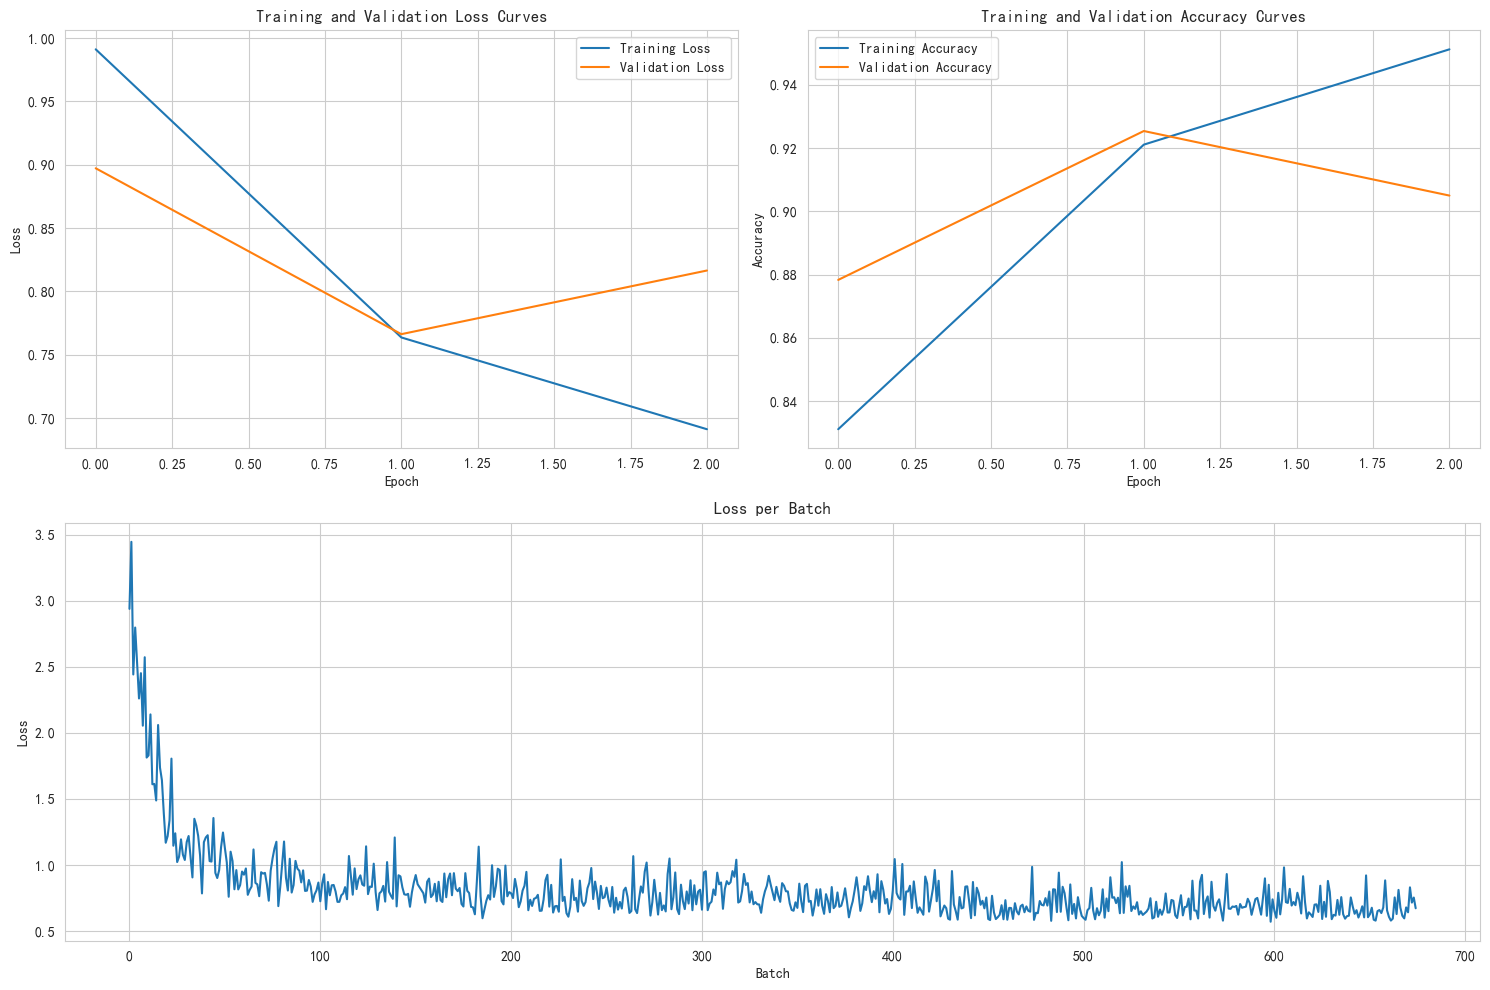

图表已保存为 'training_history.png'


In [36]:
print("绘制训练历史图表...")
plt.figure(figsize=(15, 10))

# 绘制损失曲线
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# 绘制准确率曲线
plt.subplot(2, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()

# 绘制每个batch的损失曲线
plt.subplot(2, 1, 2)
plt.plot(range(len(history['batch_losses'])), history['batch_losses'])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss per Batch')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print(f"图表已保存为 'training_history.png'")


In [43]:
# 加载最佳模型

best_model = create_model(num_classes=len(classes), mode='test')
best_model.load_state_dict(torch.load('best_vit_model.pth'))
print("最佳模型加载完成")

# 测试模型
print("\n在测试集上评估模型...")

conf_matrix, report, accuracy, y_true, y_pred = test_model(best_model, test_loader, classes)

# 打印测试结果
print(f"\n测试准确率: {accuracy:.4f}")
print("\n分类报告:")
print(report)
print("\n混淆矩阵:")
print(conf_matrix)



最佳模型加载完成

在测试集上评估模型...
测试进度: 75/75 批次
测试完成! 总体准确率: 0.9433

测试准确率: 0.9433

分类报告:
              precision    recall  f1-score   support

 Agriculture       0.96      0.94      0.95       160
     Airport       0.81      0.93      0.87       160
       Beach       1.00      0.93      0.96       160
        City       0.98      0.98      0.98       160
      Desert       0.98      0.96      0.97       160
      Forest       0.95      0.96      0.96       160
   Grassland       0.99      0.95      0.97       160
     Highway       0.98      0.97      0.98       160
        Lake       0.82      0.99      0.90       160
    Mountain       0.89      0.97      0.93       160
     Parking       1.00      0.82      0.90       160
        Port       0.92      0.96      0.94       160
     Railway       0.99      0.93      0.96       160
 Residential       0.99      1.00      1.00       160
       River       0.96      0.85      0.90       160

    accuracy                           0.94      2400


绘制混淆矩阵...


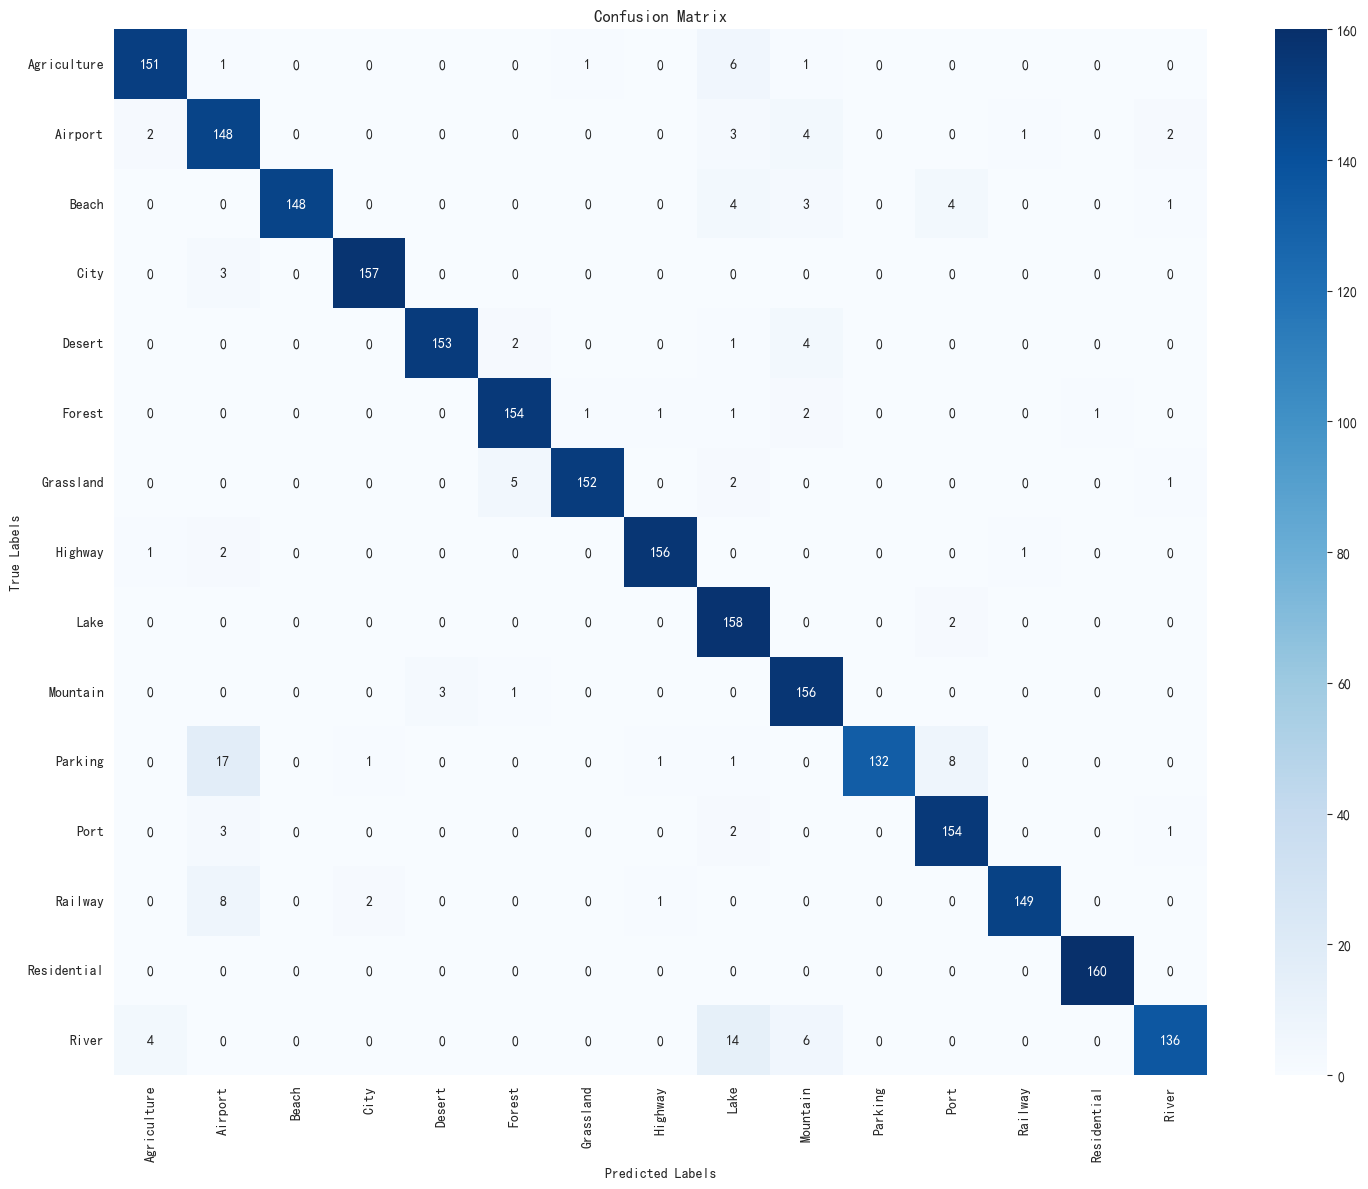

混淆矩阵已保存为 'confusion_matrix.png'


In [38]:
# 可视化混淆矩阵
plot_confusion_matrix(conf_matrix, classes)